In [1]:
import os, sys
sys.path.insert(1, '../')
import pickle

import pandas as pd
import numpy as np
from torch import nn
from collections import OrderedDict
from speed_predictor import test_model
from speed_predictor.utils import make_dataloader_data
import optuna
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import matplotlib.pyplot as plt
import disp_utils as du
from utils import MAE

import importlib

import os
import optuna
import pickle
import numpy as np
import matplotlib.pyplot as plt
import utils as utils
from optuna.trial import TrialState as ts
import disp_utils as du

In [2]:
study_names = [s.study_name for s in optuna.study.get_all_study_summaries("sqlite:///experimenty/00.db")]
study_dirs = os.listdir('experimenty')

print('Studie:')
print('\n'.join(study_names))
print('\nAdresáře:')
print('\n'.join(study_dirs))

Studie:
00_MSELoss
00_L1Loss_sigmoid
04_L1Loss_sigmoid_10_10
00_L1Loss_sigmoid_006
04_L1Loss_sigmoid_006_10_10
04_L1Loss_sigmoid_006_variable_windows
04_L1Loss_sigmoid_006_10_10_blurred
00_L1Loss_sigmoid_blurred
04_L1Loss_sigmoid_006_20_20_blurred
04_L1Loss_sigmoid_006_10_10_blurred_stops
00_L1Loss_sigmoid_2
study_single_l1loss_sigmoid_small
study_single_l1loss_sigmoid_small_blur
study_single_l1loss_sigmoid_small2
study_single_l1loss_sigmoid_small_stops
study_single_l1loss_sigmoid_small_blur_stops
study_multi_10_10_l1loss_sigmoid_small_blur_stops

Adresáře:
study_3_single_blur_stop
study_2_single_stop
legacy
study_0_single
study_4_multi_10_10_blur_stop
study_1_single_blur
00.db


In [3]:
study_name = 'study_multi_10_10_l1loss_sigmoid_small_blur_stops'
study_dir = 'study_4_multi_10_10_blur_stop'

In [4]:
if os.path.isfile(f'results/{study_name}.pickle'):
    with open(f'results/{study_name}.pickle', 'rb') as f:
        test_results = pickle.load(f)

else:
    train_module = importlib.import_module(f'experimenty.{study_dir}.train')
    test_results = test_model(
        experiment_dir=os.path.join('experimenty', study_dir),
        study_name=study_name,
        scaler_name=f'scaler_{study_name}.pickle',
        model_fn=train_module.define_model,
        blur=True,
        stops=True
    )

    with open(f'results/{study_name}.pickle', 'wb') as f:
        pickle.dump(test_results, f)

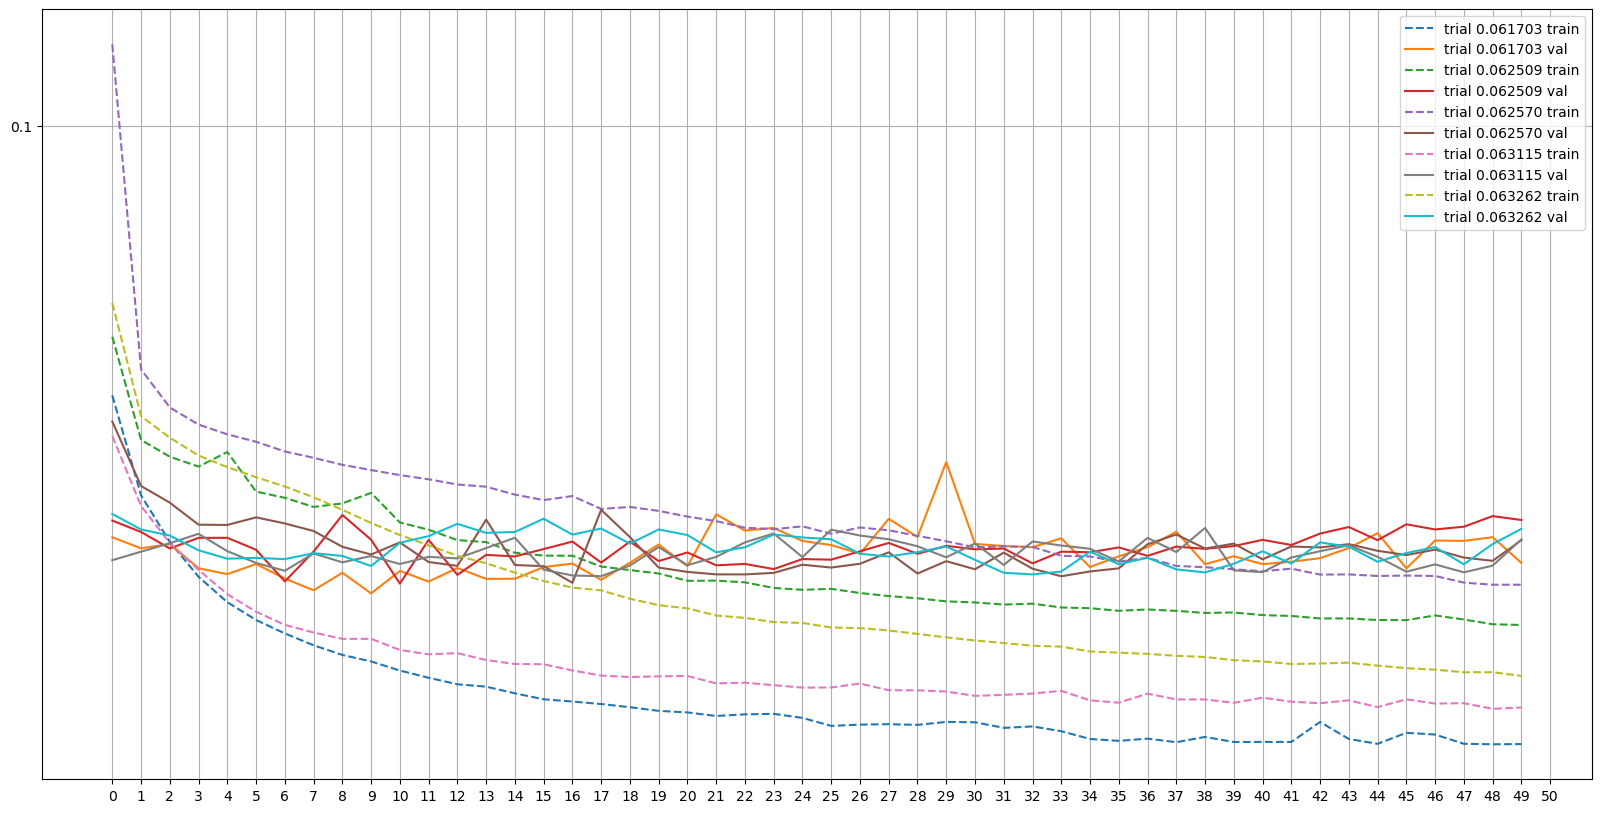

In [7]:
history = du.load_study_history(study_name, f'experimenty/{study_dir}', 'sqlite:///experimenty/00.db')
du.plot_study_history(history, k_best=5)

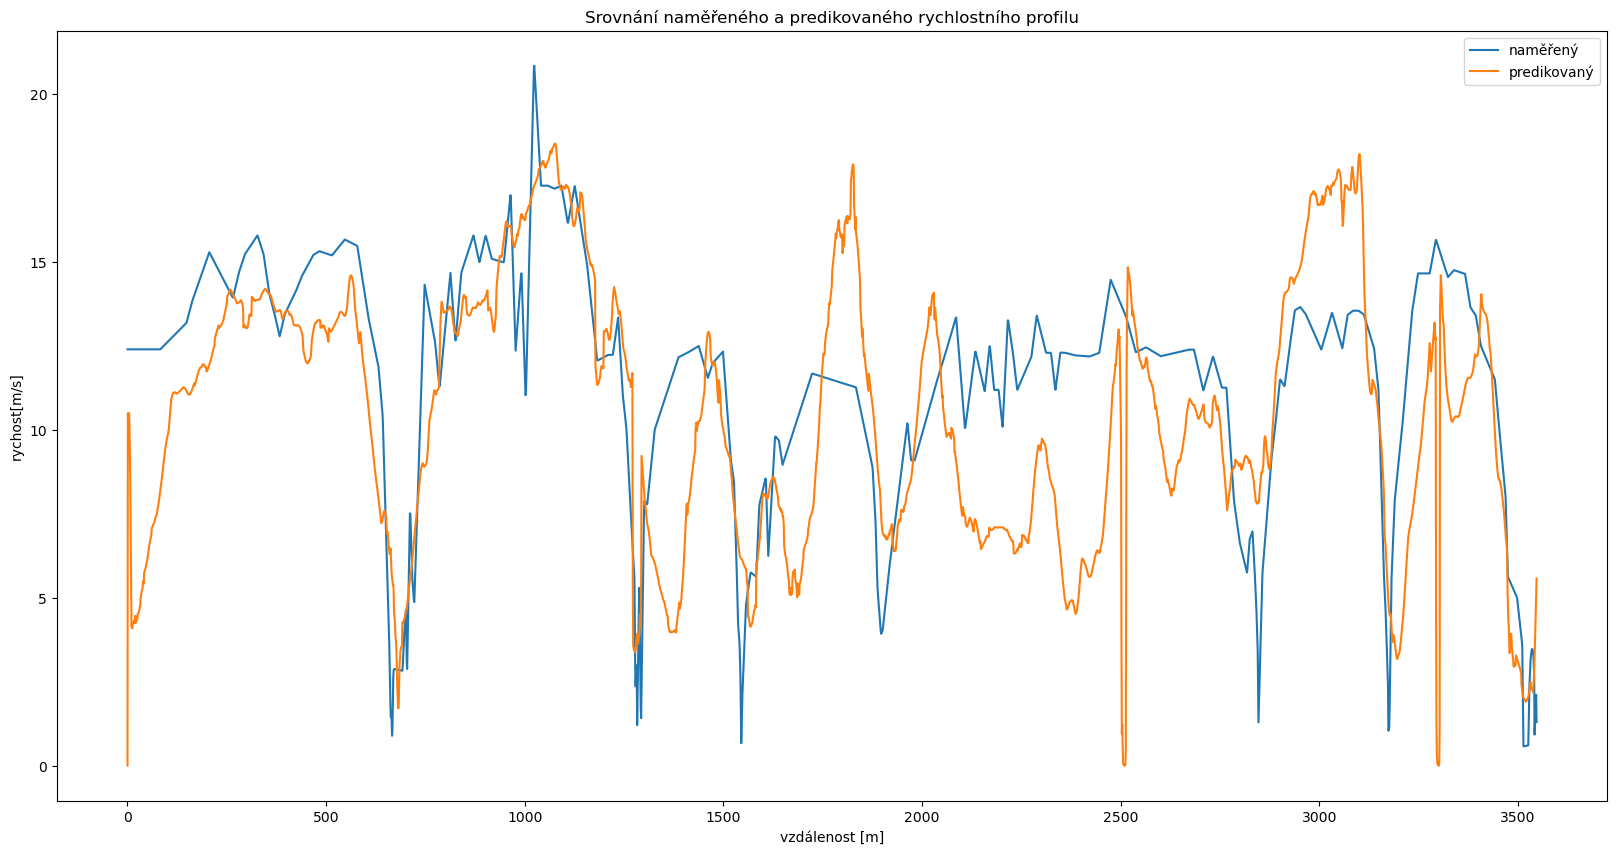

In [8]:
du.speed_profile(test_results, 190)

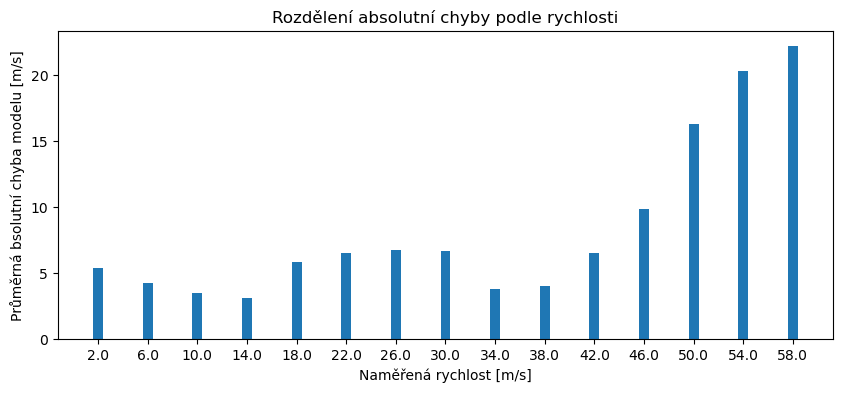

In [9]:
du.mae_mean_clustered(test_results)

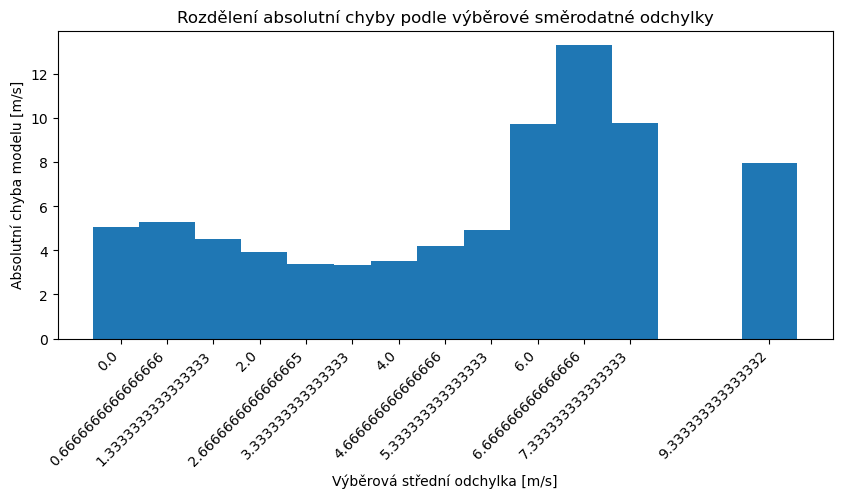

In [10]:
du.mae_std_clustered(test_results)

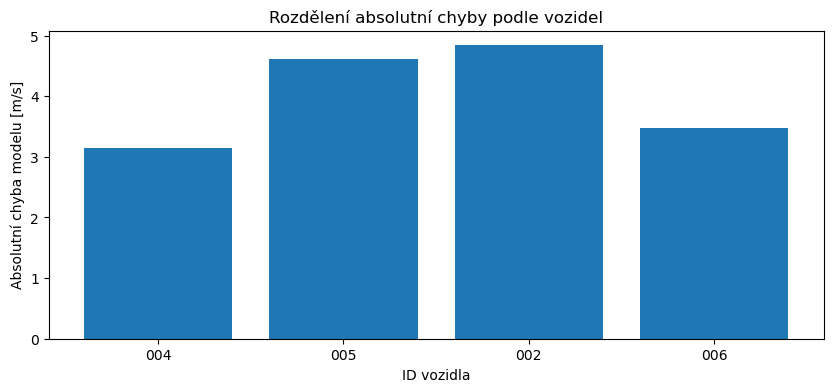

In [11]:
du.mae_cars(test_results)

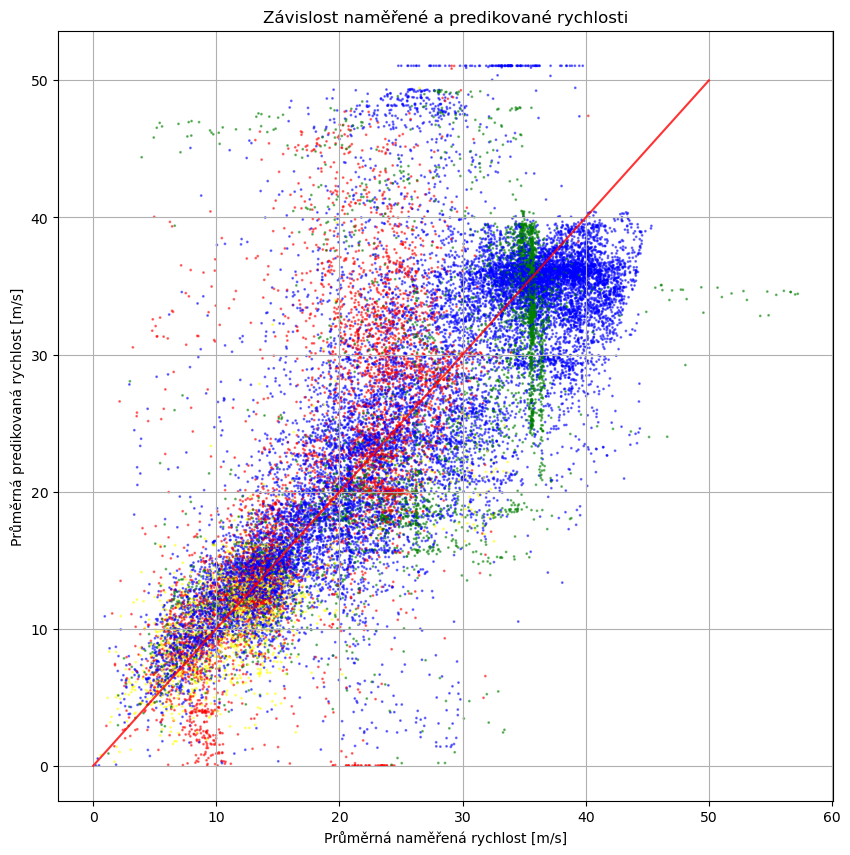

In [12]:
du.model_to_measured(test_results)

In [13]:
du.print_res(test_results)

Overall results:
Mean MAE:          3.818 mps
Median MAE:        3.099 mps
Mean MBD:          0.301 mps
Median MBD:        0.391 mps
Improvement ratio: 59.3%

Carwise results:
004
Mean MAE:          3.138 mps
Median MAE:        2.983 mps
Mean MBD:          0.810 mps
Median MBD:        0.769 mps
005
Mean MAE:          4.613 mps
Median MAE:        3.203 mps
Mean MBD:          0.299 mps
Median MBD:        0.517 mps
002
Mean MAE:          4.838 mps
Median MAE:        3.709 mps
Mean MBD:          -1.571 mps
Median MBD:        -0.843 mps
006
Mean MAE:          3.481 mps
Median MAE:        2.822 mps
Mean MBD:          1.198 mps
Median MBD:        1.614 mps

Speedwise results


In [14]:
#sorted([(dr[0], dr[1]['pth'], dr[1]['MAE'], len(dr[1]['measured'])) for dr in enumerate(test_results['drives_results'])], key=lambda x:x[2])

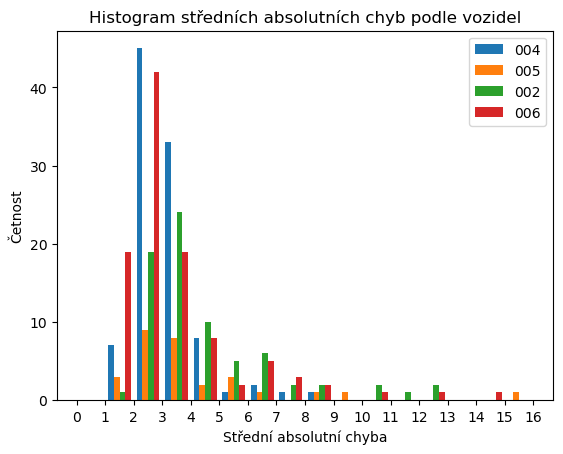

In [15]:
cars = list(test_results['car_results'].keys())
data = {}
for d in test_results['drives_results']:
    car_id = d['pth'].split('-')[1]
    if car_id not in data.keys():
        data[car_id] = []
    data[car_id].append(d['MAE'])
    
y = [data[k] for k in data.keys()]
x = list(data.keys())

fig, ax = plt.subplots()
counts, bins, patches = plt.hist(y, label=x, bins=np.arange(17))
ax.set_xticks(bins)

plt.title('Histogram středních absolutních chyb podle vozidel')
plt.xlabel('Střední absolutní chyba')  
plt.ylabel('Četnost')
plt.legend(loc='upper right')
plt.show()